<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/shareofglobalc02emissionstepwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels pandas numpy

import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Shareofglobalco2.xlsx to Shareofglobalco2.xlsx


In [3]:
import pandas as pd

# Name of uploaded file
file_name = 'Shareofglobalco2.xlsx'

# Read data from the required sheet
df = pd.read_excel(file_name, sheet_name='Sheet1', engine='openpyxl') # Pass file_name and specify sheet_name

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df

,Year,BRI Investments (USD millions),Total Population,GDP (USD Billion),Annual CO2 emissions (millon tonnes),Share of global CO2 emissions (%)
0,2015,520.40,199.427,299.96,150.59,0.43
1,2016,893.25,203.631,313.63,178.03,0.50
2,2017,2296.00,207.906,339.21,218.36,0.61
3,2018,2062.00,212.228,356.13,210.35,0.57
4,2019,2907.00,216.565,320.91,207.62,0.56
5,2020,1600.00,220.892,300.43,230.75,0.66
6,2021,2400.00,225.199,348.52,247.90,0.67
7,2022,2716.00,235.824,374.79,223.83,0.60
8,2023,1440.00,240.486,338.37,200.67,0.53


In [4]:
#Generate summary statistics, and round everything to 2 decimal places
summary=df.describe().round(2)
summary

,Year,BRI Investments (USD millions),Total Population,GDP (USD Billion),Annual CO2 emissions (millon tonnes),Share of global CO2 emissions (%)
count,9.00,9.00,9.00,9.00,9.00,9.00
mean,2019.00,1870.52,218.02,332.44,207.57,0.57
std,2.74,815.75,14.02,25.64,28.98,0.08
min,2015.00,520.40,199.43,299.96,150.59,0.43
25%,2017.00,1440.00,207.91,313.63,200.67,0.53
50%,2019.00,2062.00,216.56,338.37,210.35,0.57
75%,2021.00,2400.00,225.20,348.52,223.83,0.61
max,2023.00,2907.00,240.49,374.79,247.90,0.67


In [5]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    # Initialize df with data_cleaned to ensure it's defined
    df = df.copy()

    # Drop rows with any missing values
    df = df.dropna()

    while True:
        #Adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df

In [6]:
predictor_vars=['BRI Investments (USD millions)', 'Total Population', 'GDP (USD Billion)']

vif = drop_column_using_vif_(df[predictor_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 2.028247451233351
The columns remaining after VIF selection are:
Index(['BRI Investments (USD millions)', 'Total Population',
       'GDP (USD Billion)'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Matrix')

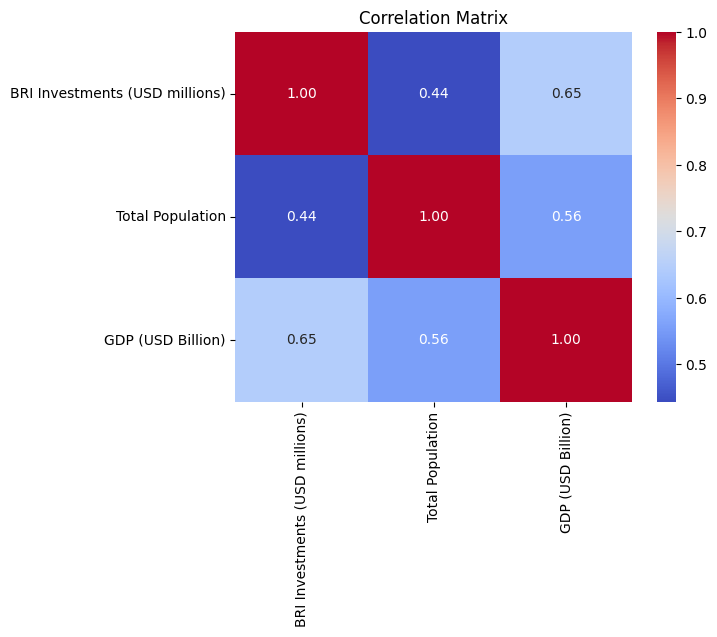

In [7]:
!pip install seaborn # install seaborn
import seaborn as sns # import seaborn
import matplotlib.pyplot as plt # import pyplot for using title

sns.heatmap(df[['BRI Investments (USD millions)', 'Total Population', 'GDP (USD Billion)']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [8]:
#Define dependent variable (environmental indicator, e.g., CO2 emissions)
y = df['Share of global CO2 emissions (%)']  # This is your dependent variable

#Define the independent variables (explanatory variables)
X = df[['BRI Investments (USD millions)', 'Total Population', 'GDP (USD Billion)']]

#Add a constant term (intercept) to the model
X = sm.add_constant(X)

In [9]:
#Function for backward elimination
def backward_elimination(X, y, significance_level=0.05):
    # Start with all predictors
    X_selected = X.copy()

    while True:
        # Fit the model with the current predictors
        model = sm.OLS(y, X_selected).fit()

        # Get the p-values of the variables
        p_values = model.pvalues[1:]  # Exclude intercept

        # Check for the highest p-value
        max_p_value = p_values.max()

        # If the highest p-value is greater than the significance level, remove the variable
        if max_p_value > significance_level:
            excluded_var = p_values.idxmax()
            X_selected = X_selected.drop(columns=[excluded_var])
            print(f"Removed variable: {excluded_var} with p-value: {max_p_value:.4f}")
        else:
            # If all variables have p-values below the significance level, break the loop
            break

    return model

In [10]:
# Perform backward elimination
final_model = backward_elimination(X, y)

# Print the summary of the final model
print("\nFinal Model Summary:")
print(final_model.summary())

Removed variable: GDP (USD Billion) with p-value: 0.6702
Removed variable: Total Population with p-value: 0.5948

Final Model Summary:
                                    OLS Regression Results                                   
Dep. Variable:     Share of global CO2 emissions (%)   R-squared:                       0.451
Model:                                           OLS   Adj. R-squared:                  0.373
Method:                                Least Squares   F-statistic:                     5.754
Date:                               Sun, 26 Jan 2025   Prob (F-statistic):             0.0476
Time:                                       11:48:29   Log-Likelihood:                 13.595
No. Observations:                                  9   AIC:                            -23.19
Df Residuals:                                      7   BIC:                            -22.80
Df Model:                                          1                                         
Covariance Type:   

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
#Function to perform Stepwise Regression
def stepwise_regression(X, y, direction="both", threshold_in=0.05, threshold_out=0.10):
    """
    Performs stepwise regression using both forward and backward elimination.
    """
    initial_list = X.columns.tolist()
    while True:
        changed = False
        #Forward Step: Adding variables to the model
        if direction in ["both", "forward"]:
            model = sm.OLS(y, X[initial_list]).fit()
            p_values = model.pvalues[1:]  # Exclude intercept
            max_p_value = p_values.max()
            if max_p_value > threshold_in:
                excluded_var = p_values.idxmax()
                initial_list.remove(excluded_var)
                changed = True

        #Backward Step: Removing variables from the model
        if direction in ["both", "backward"]:
            model = sm.OLS(y, X[initial_list]).fit()
            p_values = model.pvalues[1:]  # Exclude intercept
            max_p_value = p_values.max()
            if max_p_value > threshold_out:
                excluded_var = p_values.idxmax()
                initial_list.remove(excluded_var)
                changed = True

        # If no change, break the loop
        if not changed:
            break

    # Final model with selected variables
    final_model = sm.OLS(y, X[initial_list]).fit()
    return final_model

# Perform stepwise regression
stepwise_model = stepwise_regression(X, y)

# Print the summary of the final model
print(stepwise_model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Share of global CO2 emissions (%)   R-squared:                       0.451
Model:                                           OLS   Adj. R-squared:                  0.373
Method:                                Least Squares   F-statistic:                     5.754
Date:                               Sun, 26 Jan 2025   Prob (F-statistic):             0.0476
Time:                                       11:48:48   Log-Likelihood:                 13.595
No. Observations:                                  9   AIC:                            -23.19
Df Residuals:                                      7   BIC:                            -22.80
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                                     coef    std err        

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)
